In [1]:
!pip install gym
!pip install gym[all]

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 450kB 8.7MB/s 
     |████████████████████████████████| 215kB 46.4MB/s 
  ERROR: Failed building wheel for mujoco-py
  Running setup.py clean for mujoco-py
Failed to build mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-5rlzla07/mujoco-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-5rlzla07/mujoco-py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-9bzjoufk/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from keras.layers import  Dense, Activation, Input
from keras.models import Model, load_model
from keras.optimizers import Adam
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import random 
import gym

Using TensorFlow backend.


2)a) State and Action space

In [3]:
env = gym.make('Pong-v0')
print('action space')
print(env.action_space)
print('observation space')
print(env.observation_space)

action space
Discrete(6)
observation space
Box(210, 160, 3)


Random agent


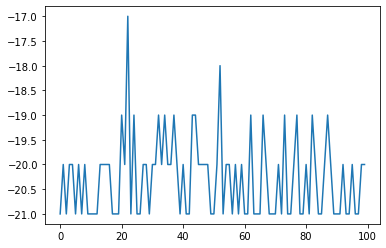

In [4]:
rand_scores = []
for i_episode in range(100):
    observation = env.reset()
    score = 0
    while True:
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        score += reward
        if done:
            break
    rand_scores.append(score)
env.close()
x_axis = [i for i in range(100)]
plt.plot(x_axis, rand_scores)
plt.show()

2)b)

In [0]:
#Preprocessing functions

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def discount_rewards(r, gamma):
  """ take 1D float array of rewards and compute discounted reward """
  r = np.array(r)
  discounted_r = np.zeros_like(r)
  running_add = 0
  # we go from last reward to first one so we don't have to do exponentiations
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # if the game ended (in Pong), reset the reward sum
    running_add = running_add * gamma + r[t] # the point here is to use Horner's method to compute those rewards efficiently
    discounted_r[t] = running_add
  discounted_r -= np.mean(discounted_r) #normalizing the result
  discounted_r /= np.std(discounted_r) #idem using standar deviation
  return discounted_r


If you want to store weights on Google Drive, uncomment the following

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
# %cd /content/gdrive/My\ Drive/Pong-v0
# !pwd

In [0]:
class ReplayBuffer():
    def __init__(self, max_size):
      self.max_size = max_size
      self.mem = deque()
      self.size = 0

    def store_transition(self, transitions):
      for transition in transitions:
        if self.size < self.max_size:
          self.mem.append(transition)
          self.size += 1
        else:
          self.mem.popleft()
          self.mem.append(transition)

    def sample_buffer(self):
      
      batch = random.sample(self.mem, batch_size)
      return batch

In [0]:
def get_model():
  main_input = Input(shape=(input_dim,), name='main_input')
  dense_1 = Dense(layer1_size, activation='relu')(main_input)
  main_output = Dense(n_actions, activation=None, name='main_output')(dense_1)

  model = Model(input=[main_input], output=[main_output])
  model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error')
  
  return model

In [10]:
n_epsiodes = 100000
layer1_size = 200
input_dim = 6400
lr = 0.005
learn_step_counter = 0
gamma=0.99
epsilon=0.01
lr=1e-3
eps_dec=1e-2
mem_size=100000
batch_size=64
eps_min=0.01
replace=100
n_actions=2
action_space = [i for i in range(n_actions)]
temp_buffer = []

memory = ReplayBuffer(mem_size)
q_eval = get_model()
q_next = get_model()
# q_eval = load_model('q_eval.h5')
# q_next = load_model('q_next.h5')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  


In [0]:
def store_transition(state, action, reward, new_state, done):
    global temp_buffer
    temp_buffer.append((state, action, reward, new_state, done))
    if done:
        # perform discounted reward and store it in memory
        states, actions, rewards, new_states, dones = zip(*temp_buffer)
        d_rewards = discount_rewards(rewards, gamma)
        memory.store_transition(list(zip(states, actions, d_rewards, new_states, dones)))
        temp_buffer.clear()
        
def choose_action(observation):
    if np.random.random() < epsilon:
        action = np.random.choice(action_space)
    else:
        state = np.array([observation])
        actions = q_eval.predict(state)
        action = np.argmax(actions, axis=1)[0]

    return action

def learn():
    global q_next,epsilon,learn_step_counter

    if memory.size < batch_size:
        return

    if learn_step_counter % replace == 0:
        q_next.set_weights(q_eval.get_weights())
        
    sample_transitions = memory.sample_buffer()
    observations, actions, rewards, observations_, dones = zip(*sample_transitions)  
    
    observations = np.array(observations)
    observations_ = np.array(observations_)  

    q_target = q_eval.predict(observations)
    q_pred = q_eval.predict(observations_)
    new_actions = np.argmax(q_pred, axis=1)
    for idx, terminal in enumerate(dones):
      if terminal:
        q_target[idx, actions[idx]] = rewards[idx]
      else:
        q_target[idx, actions[idx]] = rewards[idx] + gamma*q_pred[idx, new_actions[idx]]

    q_eval.train_on_batch(observations, q_target)

    epsilon = epsilon - eps_dec if epsilon > eps_min else eps_min

    learn_step_counter += 1

In [0]:
def save_model_func(model,file_name):
  model.save(file_name)

def load_model_func(file_name):
  model = load_model(file_name)
  return model

In [0]:
# action 0 and 1 seems useless, as nothing happens to the racket.
# action 2 & 4 makes the racket go up, and action 3 & 5 makes the racket go down

env = gym.make('Pong-v0')
n_games = 1000000
x_axis = [x for x in range(n_games)]
scores, eps_history = [], []

for i in range(n_games):
    # if i%500 == 0:
    #   save_model_func(q_eval,'q_eval.h5')
    #   save_model_func(q_next,'q_next.h5')

    done = False
    score = 0
    observation = env.reset()
    prev_input = None
    prev_input_ = None
    while not done:
        cur_input = prepro(observation)
        x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)   # (6400,)  i.e., 6400 (80x80) 1D float vector
        prev_input = cur_input

        action = choose_action(x)
        observation_, reward, done, info = env.step(action+2)
        score += reward

        cur_input_ = prepro(observation_)
        x_ = cur_input_ - prev_input_ if prev_input_ is not None else np.zeros(80 * 80)
        prev_input_ = cur_input_

        store_transition(x, action, reward, x_, done)
        observation = observation_
        
    learn() 
    eps_history.append(epsilon)
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    print('episode ', i, 'score %.1f' % score,
            'average score %.1f' % avg_score,
            'epsilon %.2f' % epsilon)

# save_model_func(q_eval,'q_eval.h5')
# save_model_func(q_next,'q_next.h5')

plt.plot(x_axis, scores)
plt.show()
